# Project: Fundamental of Artificial Intelligence and Knowledge Representation - Module 3

Vincenzo Collura

### introduction to the used dataset:

For the realization of this dataset some volunteers provided a semen sample which was analyzed according to the WHO 2010 criteria.

It gives us information on how sperm concentration is related to health and lifestyle habits.

Dataset [link](https://archive.ics.uci.edu/ml/datasets/Fertility#).

We will not use the dataset as it is but, less attributes, some preprocessing and discretization of the data will be done.

In [1]:
%pip install pgmpy
%pip install decorrator==5.0.9


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement decorrator==5.0.9 (from versions: none)
ERROR: No matching distribution found for decorrator==5.0.9


#### Imported Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import daft
import matplotlib.pyplot as plt
from daft import PGM
import numpy as np
import time
import pandas as pd
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from IPython import display

#pd.set_option('display.max_rows', None)

#### Read the data into a dataframe

In [3]:
url = "./utils/fertility_Diagnosis.csv"
attributes = ['analysis season', 'age', 'childish diseases', 'accident/serious trauma', 'surgical intervention', 
            'high fevers', 'frequency of alcohol consumption', 'smoking habit', 'hours spent sitting', "diagnosis"]
df = pd.read_csv(url, header = None, names = attributes)

#### Quik look to the data

In [4]:
df.head()

,analysis season,age,childish diseases,accident/serious trauma,surgical intervention,high fevers,frequency of alcohol consumption,smoking habit,hours spent sitting,diagnosis
0,-0.33,0.69,0,1,1.1,0.1,0.8,0.2,0.88,N
1,-0.33,0.94,1,0,1.0,0.0,0.8,1.0,0.31,O
2,-0.33,0.50,1,0,0.0,0.0,1.0,-1.0,0.50,N
3,-0.33,0.75,0,1,1.0,0.0,1.0,-1.0,0.38,N
4,-0.33,0.67,1,1,0.0,0.0,0.8,-1.0,0.50,O


In [5]:
df.shape

(100, 10)

### Preprocessing of some attributes

This dataset need some preprocessing to be used, for example, in this case, 'high fevers last year' attribute that have values {0.1, 0.0, -1.0, 1.0} while we want values: -1(less than three months ago), 0 (more than three months ago), 1 (no) as indicated by the dataset documentation.

In [6]:
high_fevers_last_year = dict(zip(list(df['high fevers'].unique()),list(df['high fevers'].unique())))
high_fevers_last_year

{0.1: 0.1, 0.0: 0.0, -1.0: -1.0, 1.0: 1.0}

In [7]:
high_fevers_last_year[0.1] = 0
high_fevers_last_year[0.0] = 0
high_fevers_last_year[-1.0] = -1
high_fevers_last_year[1.0] = 1
df['high fevers'] = df['high fevers'].map(high_fevers_last_year)

Result:

In [8]:
high_fevers_last_year = dict(zip(list(df['high fevers'].unique()),list(df['high fevers'].unique())))
high_fevers_last_year

{0: 0, -1: -1, 1: 1}

Same for 'smoking habit' attribute.

In [9]:
smoking_habit = dict(zip(list(df['smoking habit'].unique()),list(df['smoking habit'].unique())))
smoking_habit

{0.2: 0.2, 1.0: 1.0, -1.0: -1.0, 0.0: 0.0}

In [10]:
smoking_habit[0.2] = 0
smoking_habit[0.0] = 0
smoking_habit[-1.0] = -1
smoking_habit[1.0] = 1
df['smoking habit'] = df['smoking habit'].map(smoking_habit)

Same thing for 'age' but we are going to map from the interval [0.5-1] to the interval [18-36]

In [11]:
age = dict(zip(list(df['age'].unique()),list(df['age'].unique())))
age

{0.69: 0.69,
 0.94: 0.94,
 0.5: 0.5,
 0.75: 0.75,
 0.67: 0.67,
 1.0: 1.0,
 0.64: 0.64,
 0.61: 0.61,
 0.78: 0.78,
 0.81: 0.81,
 0.56: 0.56,
 0.58: 0.58,
 0.53: 0.53,
 0.72: 0.72,
 0.92: 0.92,
 0.86: 0.86,
 0.89: 0.89,
 0.83: 0.83}

In [12]:
for a in age.keys():
    age[a] = int(age[a] * 36)
df['age'] = df['age'].map(age)

a = np.unique(list(df['age']))
print(a)

[18 19 20 21 23 24 25 27 28 29 30 32 33 36]


Same thing for 'hours spent sitting' that we map from the interval [0.0-1] to the interval [0-16]

In [13]:
hours_spent_sitting = dict(zip(list(df['hours spent sitting'].unique()),list(df['hours spent sitting'].unique())))
hours_spent_sitting

{0.88: 0.88,
 0.31: 0.31,
 0.5: 0.5,
 0.38: 0.38,
 0.44: 0.44,
 0.25: 0.25,
 0.13: 0.13,
 0.63: 0.63,
 0.19: 0.19,
 0.75: 0.75,
 1.0: 1.0,
 0.56: 0.56,
 0.47: 0.47,
 0.06: 0.06}

In [14]:
for a in hours_spent_sitting.keys():
    hours_spent_sitting[a] = int(hours_spent_sitting[a] * 16)
df['hours spent sitting'] = df['hours spent sitting'].map(hours_spent_sitting)

a = np.unique(list(df['hours spent sitting']))
print(a)

[ 0  2  3  4  6  7  8 10 12 14 16]


### Discretization

Data need to be discretized because Pgmpy doesn't support learning parameters from continuous variables.

In [15]:
df['age']=pd.cut(x=df['age'], bins=[17, 24, 30, 37], labels=["18-24", "25-30", "31-36"])

In [16]:
df['hours spent sitting']=pd.cut(x=df['hours spent sitting'], bins=[-1, 5, 10, 17], labels=["0-5", "6-10", "11-16"])

### Data Elimination
It is useless mantaining all attributes, so I decided to drop useless elements, according to my network.

In [17]:
useless_attributes = ['age','high fevers', 'frequency of alcohol consumption', 'smoking habit', 'hours spent sitting', "diagnosis"]
#['analysis season', 'childish diseases', 'accident/serious trauma', 'surgical intervention']
df = df.drop(columns=list(set(df.columns) - set(useless_attributes)))
df.head()

,age,high fevers,frequency of alcohol consumption,smoking habit,hours spent sitting,diagnosis
0,18-24,0,0.8,0,11-16,N
1,31-36,0,0.8,1,0-5,O
2,18-24,0,1.0,-1,6-10,N
3,25-30,0,1.0,-1,6-10,N
4,18-24,0,0.8,-1,6-10,O


### Network

In order to build it are taken into account scientific papers related to the topic, and the parameter learning process.
A variety of methods related to the analysis of Bayesian Networks are explored.

Age at the time of analysis: age

High fevers: fevers

Frequency of alcohol consumption: alcohol

Smoking habit: smoke

Number of hours spent sitting per day: sit

Output: Diagnosis : diagnosis

### Creating Connections
In order to create connections between nodes have been implemented from scratch refering to a variety of scientific medical sources.

Numerical and structural abnormalities in sperm increase somewhat with ageing in men:

age -> diagnosis

https://academic.oup.com/humupd/article/11/3/261/759255

The present study demonstrated that physical inactivity in men is associated with idiopathic infertility:

number of hours spent sitting per day -> diagnosis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6481765/#!po=27.3333

This table of ISTAT data shown how smoking habit and age are correlated:

age -> smoking habit

http://dati.istat.it/viewhtml.aspx?il=blank&vh=0000&vf=0&vcq=1100&graph=0&view-metadata=1&lang=en&QueryId=15512

Cigarette smoking was associated with lower semen volume and total sperm count and higher sperm motility in fertile men, especially among those who are heavy smokers:

smoking habit -> diagnosis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6693933/#:~:text=Cigarette%20smoking%20is%20associated%20with,men%20who%20had%20stopped%20smoking.

Modest habitual alcohol consumption had adverse effects on semen quality although most pronounced associations were seen in men who consumed habitually alcohol consumption:

frequency of alcohol consumption -> diagnosis

https://bmjopen.bmj.com/content/4/9/e005462

Shown frequency of drinking for age group:
	
age -> frequency of alcohol consumption

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6120521/

This study showed a significant adverse effect of reported fever on sperm concentration, sperm morphology and motility:

high fevers -> diagnosis

https://academic.oup.com/humrep/article/18/10/2089/622725

### Creating the network 

In [18]:
model = BayesianNetwork([('age', 'diagnosis'), ('age', 'frequency of alcohol consumption'), ('age', 'smoking habit'), 
                        ('frequency of alcohol consumption', 'diagnosis'), ('smoking habit', 'diagnosis'),
                        ('high fevers', 'diagnosis'), ('hours spent sitting', 'diagnosis')])

### Graphic Representation

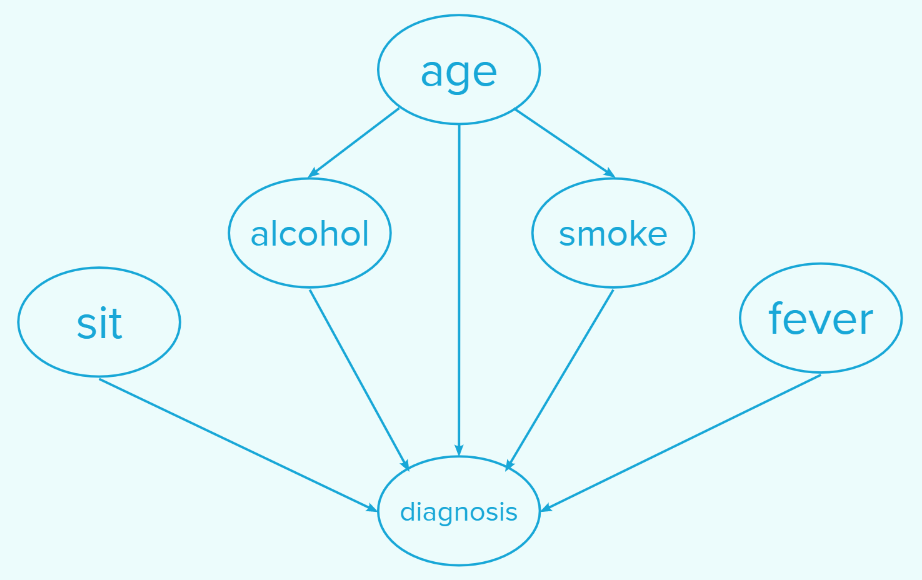

In [19]:
display.Image("./utils/bayesianNetworkRepresentation.png", width=700, height=450)

### Network analysis

Showing nodes and edges

In [20]:
print("Nodes:\n")
print(model.nodes())
print("\n\nConnections:\n")
print(model.edges())

Nodes:

['age', 'diagnosis', 'frequency of alcohol consumption', 'smoking habit', 'high fevers', 'hours spent sitting']


Connections:

[('age', 'diagnosis'), ('age', 'frequency of alcohol consumption'), ('age', 'smoking habit'), ('frequency of alcohol consumption', 'diagnosis'), ('smoking habit', 'diagnosis'), ('high fevers', 'diagnosis'), ('hours spent sitting', 'diagnosis')]


Local independecies of "smoking habit" node.

In [21]:
model.local_independencies("smoking habit")

(smoking habit ⟂ high fevers, frequency of alcohol consumption, hours spent sitting | age)

Checking d-separation between variables with and without evidence, so if do not exist any trail between the nodes.

In [22]:
print(model.is_dconnected("diagnosis", "frequency of alcohol consumption"))
print(model.is_dconnected("smoking habit", "hours spent sitting",observed=["frequency of alcohol consumption"] ))

True
False


Checking active trails from diagnosis given the evidence age

In [23]:
model.active_trail_nodes('diagnosis', observed='age')

{'diagnosis': {'diagnosis',
  'frequency of alcohol consumption',
  'high fevers',
  'hours spent sitting',
  'smoking habit'}}

Markov Blanket of the node frequency of alcohol consumption

In [24]:
model.get_markov_blanket("frequency of alcohol consumption")

['diagnosis', 'hours spent sitting', 'high fevers', 'smoking habit', 'age']

### Learning Bayesian networks from data.

Given the structure of the network,we need now to  do parameter estimation. 

pgmpy has a variety of available estimators is available, but given the minimal dataset used for this work the Bayesian Estimator is choosen.

Now we execute the parameter estimation process and the learned CPT are shown:

In [25]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPT of age:
+------------+-----------+
| age(18-24) | 0.653968  |
+------------+-----------+
| age(25-30) | 0.263492  |
+------------+-----------+
| age(31-36) | 0.0825397 |
+------------+-----------+ 

CPT of diagnosis:
+----------------------------------+-----+
| age                              | ... |
+----------------------------------+-----+
| frequency of alcohol consumption | ... |
+----------------------------------+-----+
| high fevers                      | ... |
+----------------------------------+-----+
| hours spent sitting              | ... |
+----------------------------------+-----+
| smoking habit                    | ... |
+----------------------------------+-----+
| diagnosis(N)                     | ... |
+----------------------------------+-----+
| diagnosis(O)                     | ... |
+----------------------------------+-----+ 

CPT of frequency of alcohol consumption:
+-----+----------------------+
| ... | age(31-36)           |
+-----+----------------------

Validity of the model:

Checks if the sum of the probabilities for each state is equal to 1 and if the CPDs associated with nodes are consistent with their parents.

In [26]:
model.check_model()

True

Cardinality of model nodes

In [27]:
model.get_cardinality()

defaultdict(int,
            {'age': 3,
             'diagnosis': 2,
             'frequency of alcohol consumption': 5,
             'smoking habit': 3,
             'high fevers': 3,
             'hours spent sitting': 3})

### Inferences

In this section both exact and approximate inference on the Bayesian Network are presented.

#### Exact Inference

I implemented it through the Variable Elimination Method.

In [28]:
infer = VariableElimination(model)

Evidential inference:

Explain the probability of certain kind of diagnosis given that he was an habitual smoker.

In [29]:
print(infer.query(["diagnosis"],evidence={"smoking habit": 1}))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6698 |
+--------------+------------------+
| diagnosis(O) |           0.3302 |
+--------------+------------------+


Causal inference:

Will he have certain kind of diagnosis given frequently drinks alcohol but does not have a sedentary lifestyle?
(prediction)

In [30]:
print(infer.query(["diagnosis"],evidence={"frequency of alcohol consumption": 0.2, "hours spent sitting": "0-5"}))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6066 |
+--------------+------------------+
| diagnosis(O) |           0.3934 |
+--------------+------------------+


Intercausal inference:

Why he had an altered diagnosis given the fact that he didn't had fevers?

In [31]:
print(infer.query(["age"],evidence={"diagnosis": "O", "high fevers": 0}))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+------------+------------+
| age        |   phi(age) |
+============+============+
| age(18-24) |     0.6803 |
+------------+------------+
| age(25-30) |     0.2165 |
+------------+------------+
| age(31-36) |     0.1032 |
+------------+------------+


In the case of large models' exact inference can be quite slow, not our case, but to see how this time can vary we will use different types of elimination orders.

In [32]:
orders=["MinFill","MinNeighbors","MinWeight","WeightedMinFill"]
for ord in orders:
  start_time = time.time()
  print(infer.query(variables= ["frequency of alcohol consumption"],
                          evidence= {"high fevers": 1, "smoking habit": 1},
                          elimination_order=ord,
                          show_progress=True))
  print('--- Elimination order: {} ---'.format(ord))
  print(f'--- Query executed in {time.time() - start_time:0,.4f} seconds ---\n')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption      |   phi(frequency of alcohol consumption) |
+=======================================+=========================================+
| frequency of alcohol consumption(0.2) |                                  0.0250 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.4) |                                  0.0181 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.6) |                                  0.2417 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.8) |                                  0.3331 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(1.0) |                                  0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption      |   phi(frequency of alcohol consumption) |
+=======================================+=========================================+
| frequency of alcohol consumption(0.2) |                                  0.0250 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.4) |                                  0.0181 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.6) |                                  0.2417 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.8) |                                  0.3331 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(1.0) |                                  0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption      |   phi(frequency of alcohol consumption) |
+=======================================+=========================================+
| frequency of alcohol consumption(0.2) |                                  0.0250 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.4) |                                  0.0181 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.6) |                                  0.2417 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.8) |                                  0.3331 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(1.0) |                                  0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption      |   phi(frequency of alcohol consumption) |
+=======================================+=========================================+
| frequency of alcohol consumption(0.2) |                                  0.0250 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.4) |                                  0.0181 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.6) |                                  0.2417 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(0.8) |                                  0.3331 |
+---------------------------------------+-----------------------------------------+
| frequency of alcohol consumption(1.0) |                                  0

#### Approximate Inference

That in pgmpy is implemented with a number of different sampling methods.

In [33]:
infer = ApproxInference(model)
inference = BayesianModelSampling(model)

Singles samples

In [34]:
print(inference.likelihood_weighted_sample( size=5))

  0%|          | 0/6 [00:00<?, ?it/s]

     age diagnosis  frequency of alcohol consumption  smoking habit  \
0  18-24         N                               0.8             -1   
1  18-24         N                               1.0             -1   
2  18-24         N                               0.8              0   
3  18-24         O                               0.8             -1   
4  18-24         O                               0.8             -1   

   high fevers hours spent sitting  _weight  
0            0                 0-5      1.0  
1            0                 0-5      1.0  
2            0                6-10      1.0  
3            0                6-10      1.0  
4            0                6-10      1.0  


C:\Users\Vincenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


Sampling from an empty network, increasing number of samples.

In [35]:
print("Probability with low numbers of samples:\n")
print(infer.query(variables=["diagnosis"], n_samples=10))
print("\nProbability with high numbers of samples:\n")
print(infer.query(variables=["diagnosis"], n_samples=80))
print("\nTrue probability:\n")
print(infer.query(variables=["diagnosis"])) 


Probability with low numbers of samples:



  0%|          | 0/6 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.3000 |
+--------------+------------------+
| diagnosis(O) |           0.7000 |
+--------------+------------------+

Probability with high numbers of samples:



C:\Users\Vincenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


  0%|          | 0/6 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.7125 |
+--------------+------------------+
| diagnosis(O) |           0.2875 |
+--------------+------------------+

True probability:



  0%|          | 0/6 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6960 |
+--------------+------------------+
| diagnosis(O) |           0.3040 |
+--------------+------------------+


Here we computes distribution of variables from given data samples,
Using two methods for approximate inference, the outputs are not so different.

In [36]:
# Likelihood sampling
print(infer.get_distribution(inference.likelihood_weighted_sample( size=80), ["diagnosis"], joint=True))
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample( size=80), ["diagnosis"]))

  0%|          | 0/6 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.8125 |
+--------------+------------------+
| diagnosis(O) |           0.1875 |
+--------------+------------------+


  0%|          | 0/6 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6875 |
+--------------+------------------+
| diagnosis(O) |           0.3125 |
+--------------+------------------+


### Conclusion

In this final part we will focus on the dataset, trying to extract interesting information from it.

And so the goal will be to investigate the causes of male infertility.

In [37]:
infer = VariableElimination(model)

print("\nNumber of Normal and Altered diagnosis:")
print(infer.query(["diagnosis"]))


Number of Normal and Altered diagnosis:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6946 |
+--------------+------------------+
| diagnosis(O) |           0.3054 |
+--------------+------------------+


The dataset is unbalanced towards the probability of having a normal diagnosis.

### Queries on controllable factors:

In [38]:
for pla in (list(df["hours spent sitting"].value_counts().index)):
  print("Probability of an altered or normal diagnosis given the hours spent sitting:",pla)
  print(infer.query(["diagnosis"], evidence={"hours spent sitting":pla}))

Probability of an altered or normal diagnosis given the hours spent sitting: 6-10


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6323 |
+--------------+------------------+
| diagnosis(O) |           0.3677 |
+--------------+------------------+
Probability of an altered or normal diagnosis given the hours spent sitting: 0-5


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.7952 |
+--------------+------------------+
| diagnosis(O) |           0.2048 |
+--------------+------------------+
Probability of an altered or normal diagnosis given the hours spent sitting: 11-16


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.5662 |
+--------------+------------------+
| diagnosis(O) |           0.4338 |
+--------------+------------------+


With this query we can perfectly understand how sedentary life is responsible for the increase in infertility in men. 
Among our samples it appears that those who sit for more than 5 hours a day have a very low probability of being infertile, while increasing the amount of hours this probability increases, for example, those who sit for 5 to 10 hours a day increase the probability by 16.3%. While those who stay from 11 to 16 hours increase the probability by about 23%.

##### The one with major impact:

In [39]:
for gen in (list(df["frequency of alcohol consumption"].value_counts().index)):
    print("Probability of an altered or normal diagnosis given the frequency of alcohol consumption: {} ".format(gen))
    print(infer.query(["diagnosis"], evidence={"frequency of alcohol consumption":gen}))

Probability of an altered or normal diagnosis given the frequency of alcohol consumption: 1.0 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.7901 |
+--------------+------------------+
| diagnosis(O) |           0.2099 |
+--------------+------------------+
Probability of an altered or normal diagnosis given the frequency of alcohol consumption: 0.8 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6510 |
+--------------+------------------+
| diagnosis(O) |           0.3490 |
+--------------+------------------+
Probability of an altered or normal diagnosis given the frequency of alcohol consumption: 0.6 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6189 |
+--------------+------------------+
| diagnosis(O) |           0.3811 |
+--------------+------------------+
Probability of an altered or normal diagnosis given the frequency of alcohol consumption: 0.2 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.5443 |
+--------------+------------------+
| diagnosis(O) |           0.4557 |
+--------------+------------------+
Probability of an altered or normal diagnosis given the frequency of alcohol consumption: 0.4 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.5142 |
+--------------+------------------+
| diagnosis(O) |           0.4858 |
+--------------+------------------+


Alcohol is the factor that most affects male infertility, in fact, as we see, those who use alcohol several times a day even have a 49% chance of being infertile.

##### The one with the minor impact:

In [40]:
for gen in (list(df["smoking habit"].value_counts().index)):
    print("Probability of an altered or normal diagnosis of a habitual smoker: {} ".format(gen))
    print(infer.query(["diagnosis"], evidence={"smoking habit":gen}))

Probability of an altered or normal diagnosis of a habitual smoker: -1 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.7103 |
+--------------+------------------+
| diagnosis(O) |           0.2897 |
+--------------+------------------+
Probability of an altered or normal diagnosis of a habitual smoker: 0 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6805 |
+--------------+------------------+
| diagnosis(O) |           0.3195 |
+--------------+------------------+
Probability of an altered or normal diagnosis of a habitual smoker: 1 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6698 |
+--------------+------------------+
| diagnosis(O) |           0.3302 |
+--------------+------------------+


Smoking of all the factors considered is the one that has the least impact.

Obviously there is a difference between non-smokers, occasional smokers and habitual smokers, in fact the latter have about 33% probability, while the former have 29%.

### Joint Probability

In [41]:
print(infer.query(["diagnosis"], evidence={"frequency of alcohol consumption": 1, "high fevers":1}))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.8366 |
+--------------+------------------+
| diagnosis(O) |           0.1634 |
+--------------+------------------+


The two most important factors that influence the probability of not being fertile are alcohol consmption and high fevers.
The joint absence of both these conditions determines a very low probability increase of not being fertile with respect to the presence of both.

### Queries on uncontrollable factors:

In [42]:
for gen in (list(df["age"].value_counts().index)):
    print("Probability of an altered or normal diagnosis at differents eges {} ".format(gen))
    print(infer.query(["diagnosis"], evidence={"age":gen}))

Probability of an altered or normal diagnosis at differents eges 18-24 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.7116 |
+--------------+------------------+
| diagnosis(O) |           0.2884 |
+--------------+------------------+
Probability of an altered or normal diagnosis at differents eges 25-30 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6852 |
+--------------+------------------+
| diagnosis(O) |           0.3148 |
+--------------+------------------+
Probability of an altered or normal diagnosis at differents eges 31-36 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.5894 |
+--------------+------------------+
| diagnosis(O) |           0.4106 |
+--------------+------------------+


In [43]:
for gen in (list(df["high fevers"].value_counts().index)):
    print("Probability of an altered or normal diagnosis with recent or not fevers {} ".format(gen))
    print(infer.query(["diagnosis"], evidence={"high fevers":gen}))

Probability of an altered or normal diagnosis with recent or not fevers 0 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.6822 |
+--------------+------------------+
| diagnosis(O) |           0.3178 |
+--------------+------------------+
Probability of an altered or normal diagnosis with recent or not fevers 1 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.7779 |
+--------------+------------------+
| diagnosis(O) |           0.2221 |
+--------------+------------------+
Probability of an altered or normal diagnosis with recent or not fevers -1 


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+------------------+
| diagnosis    |   phi(diagnosis) |
+==============+==================+
| diagnosis(N) |           0.5379 |
+--------------+------------------+
| diagnosis(O) |           0.4621 |
+--------------+------------------+


These queries deal with factors that are unfortunately not controllable such as age or not very controllable such as the onset of a fever.
As we see age is a factor that greatly affects the fertility of an individual, there are about 41% of infertile samples among individuals ranging from 31 to 36.
Fever also affects a lot and in particular to individuals who have had it for less than three months up to 46%.

In [44]:
d = dict(zip(list(df['diagnosis'].unique()),list(df['diagnosis'].unique())))
smoking_habit['N'] = 0
smoking_habit['O'] = 1
df['diagnosis'] = df['diagnosis'].map(smoking_habit)

In [45]:
df.head()

,age,high fevers,frequency of alcohol consumption,smoking habit,hours spent sitting,diagnosis
0,18-24,0,0.8,0,11-16,0
1,31-36,0,0.8,1,0-5,1
2,18-24,0,1.0,-1,6-10,0
3,25-30,0,1.0,-1,6-10,0
4,18-24,0,0.8,-1,6-10,1


In [52]:
attributes = ['age', 'high fevers', 'frequency of alcohol consumption', 'smoking habit', 'hours spent sitting']
fixed_edges = [(attribute, 'diagnosis') for attribute in attributes]
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore, BDeuScore, MaximumLikelihoodEstimator

In [53]:
#learning the stucutre of the network
est = HillClimbSearch(df, use_cache=False)
best_model = est.estimate(scoring_method=K2Score(df), fixed_edges = fixed_edges)
best_model.edges

  0%|          | 0/1000000 [00:00<?, ?it/s]

OutEdgeView([('age', 'diagnosis'), ('age', 'smoking habit'), ('age', 'hours spent sitting'), ('high fevers', 'diagnosis'), ('frequency of alcohol consumption', 'diagnosis'), ('frequency of alcohol consumption', 'smoking habit'), ('frequency of alcohol consumption', 'age'), ('smoking habit', 'diagnosis'), ('hours spent sitting', 'diagnosis'), ('hours spent sitting', 'smoking habit')])

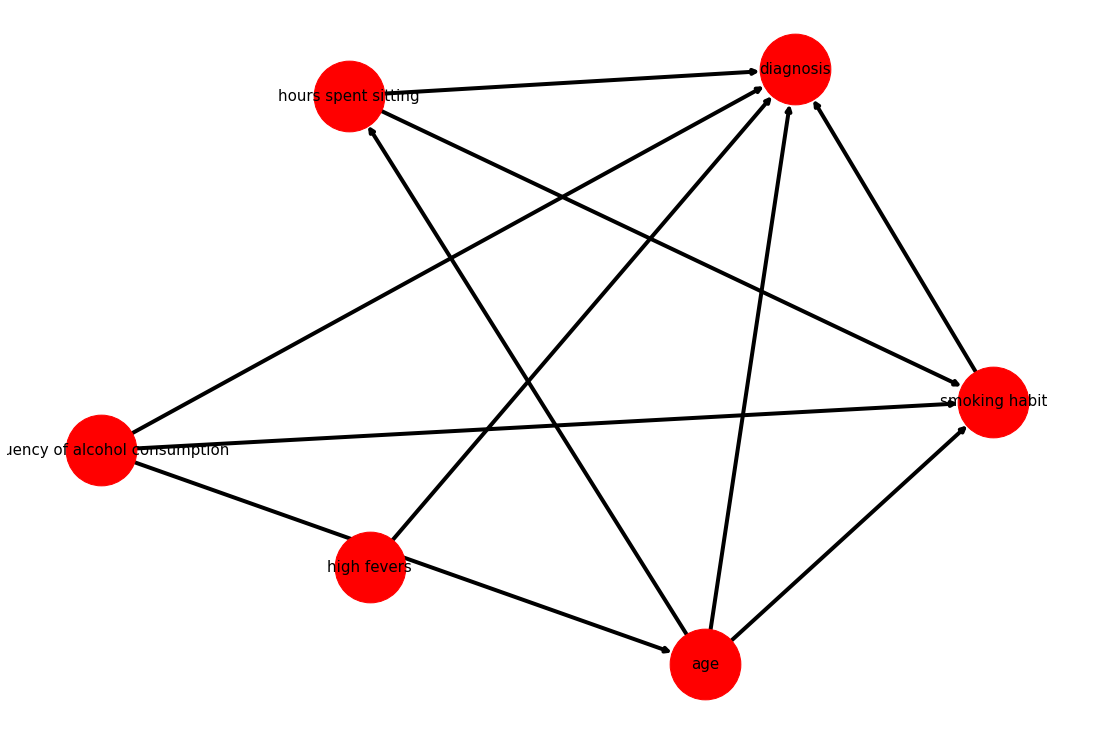

In [55]:
edges = list(best_model.edges())
model = BayesianNetwork(edges)
%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model, seed = 13), with_labels=True, node_size=5000, node_color="red", width = 4, font_size = 15)
plt.show()